## Crédits:

### Dylan Pernin et Martin Boujon (qui ont réalisé beaucoup plus que ça!)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline 

# Pre-processing

In [2]:
pData = pd.read_csv(r"Football-FullData.csv")

#Choix des features
pDataUtil = pData[['Club_Position','Height', 'Weight', 'Preffered_Foot', 'Skill_Moves',
       'Ball_Control', 'Dribbling', 'Marking', 'Sliding_Tackle', 'Standing_Tackle', 'Aggression', 'Reactions', 
       'Interceptions', 'Vision', 'Composure', 'Crossing', 'Short_Pass', 'Long_Pass',
       'Acceleration', 'Speed', 'Stamina', 'Strength', 'Balance', 'Agility', 'Jumping', 'Heading', 'Shot_Power',
       'Finishing', 'Long_Shots', 'Curve', 'Freekick_Accuracy', 'Penalties', 'Volleys']]

In [3]:
# Pré-traitement minimal 
pDataFinal = pDataUtil # copie superficielle (shallow)

In [4]:
subset = ['Club_Position','Height', 'Weight', 'Preffered_Foot', 'Skill_Moves', 'Ball_Control']
print(pDataFinal[subset].head().to_latex()) # ?.describe().to_latex())

\begin{tabular}{lllllrr}
\toprule
{} & Club\_Position &  Height & Weight & Preffered\_Foot &  Skill\_Moves &  Ball\_Control \\
\midrule
0 &            LW &  185 cm &  80 kg &          Right &            5 &            93 \\
1 &            RW &  170 cm &  72 kg &           Left &            4 &            95 \\
2 &            LW &  174 cm &  68 kg &          Right &            5 &            95 \\
3 &            ST &  182 cm &  85 kg &          Right &            4 &            91 \\
4 &            GK &  193 cm &  92 kg &          Right &            1 &            48 \\
\bottomrule
\end{tabular}



In [5]:
# Regroupement initial suivant la localisation spatiale du joueur 
pDataFinal = pDataUtil.replace(regex={'Left':'1','Right':'0','LWB':'ARG','LW':'AVG','CAM':'AVC','RWB':'ARD','RW':'AVD','LM':'MG','LCM':'MG','RCM':'MD','CM':'MC','RM':'MD','LB':'ARG','LCB':'ARG','LDM':'ARG','CDM':'ARC','RCB':'ARD','CB':'ARC','RB':'ARD','RDM':'ARD','ST':'TR','RF':'TR','LF':'TR','CF':'TR','GK':'GR','RS':'AVD','LS':'AVG','RAM':'AVD','LAM':'AVG'})

#Regroupement n°1 (10 catégories)
# pDataFinal = pDataUtil.replace(regex={'Left':'1','Right':'0','RCB':'CB','LCB':'CB','RS':'ST','LS':'ST','LM':'L','LWB':'L','LW':'L','RM':'R','RWB':'R','RW':'R','LCM':'CM','RCM':'CM','CAM':'AM','LAM':'AM','RAM':'AM','LF':'AM','RF':'AM','CF':'AM','CDM':'DM','RDM':'DM','LDM':'DM'})

#Regroupement n°2 (10 catégories), celui choisi
# pDataFinal = pDataUtil.replace(regex={'Left':'1','Right':'0','RCB':'CB','LCB':'CB','LWB':'LB','RWB':'RB','RS':'ST','LS':'ST','LM':'L','LW':'L','RM':'R','RW':'R','LCM':'CM','RCM':'CM','CAM':'AM','LAM':'AM','RAM':'AM','LF':'AM','RF':'AM','CF':'AM','CDM':'DM','RDM':'DM','LDM':'DM'})

#Regroupement n°3 (8 catégories)
#pDataFinal = pDataUtil.replace(regex={'Left':'1','Right':'0','RCB':'CB','LCB':'CB','RS':'ST','LS':'ST','LM':'L','LB':'L','LWB':'L','LW':'L','RM':'R','RB':'R','RWB':'R','RW':'R','LCM':'CM','RCM':'CM','CAM':'AM','LAM':'AM','RAM':'AM','LF':'AM','RF':'AM','CF':'AM','CDM':'DM','RDM':'DM','LDM':'DM'})

#On enlève les positions Sub (Remplaçant) et Res (Réserviste)
pDataFinal = pDataFinal[~pDataFinal['Club_Position'].isin(["Sub","Res"])]

#Permet de changer 180cm en 180 et 75kg en 75 (par exemple)
pDataFinal['Height'] = pDataFinal['Height'].str.replace(r'\D', '').astype(int)
pDataFinal['Weight'] = pDataFinal['Weight'].str.replace(r'\D', '').astype(int)

#Permet de passer le format de la colonne à int
pDataFinal['Preffered_Foot'] = pDataFinal['Preffered_Foot'].astype(int)

#Supprime les lignes incomplètes
pDataFinal = pDataFinal.dropna()

# Représentation des données

In [6]:
(pDataFinal['Preffered_Foot']).unique()

array([0, 1])

In [7]:
subset = ['Club_Position','Height', 'Weight', 'Preffered_Foot', 'Skill_Moves', 'Ball_Control']
print(pDataFinal[subset].head().to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} & Club\_Position &  Height &  Weight &  Preffered\_Foot &  Skill\_Moves &  Ball\_Control \\
\midrule
0 &           AVG &     185 &      80 &               0 &            5 &            93 \\
1 &           AVD &     170 &      72 &               1 &            4 &            95 \\
2 &           AVG &     174 &      68 &               0 &            5 &            95 \\
3 &            TR &     182 &      85 &               0 &            4 &            91 \\
4 &            GR &     193 &      92 &               0 &            1 &            48 \\
\bottomrule
\end{tabular}



<class 'pandas.core.frame.DataFrame'>
Int64Index: 6949 entries, 0 to 17481
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Club_Position      6949 non-null   object
 1   Height             6949 non-null   int64 
 2   Weight             6949 non-null   int64 
 3   Preffered_Foot     6949 non-null   int64 
 4   Skill_Moves        6949 non-null   int64 
 5   Ball_Control       6949 non-null   int64 
 6   Dribbling          6949 non-null   int64 
 7   Marking            6949 non-null   int64 
 8   Sliding_Tackle     6949 non-null   int64 
 9   Standing_Tackle    6949 non-null   int64 
 10  Aggression         6949 non-null   int64 
 11  Reactions          6949 non-null   int64 
 12  Interceptions      6949 non-null   int64 
 13  Vision             6949 non-null   int64 
 14  Composure          6949 non-null   int64 
 15  Crossing           6949 non-null   int64 
 16  Short_Pass         6949 non-null   int64 

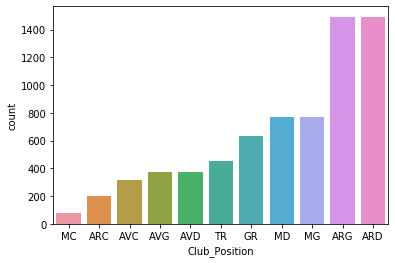

In [8]:
pDataFinal.head()
pDataFinal.info()
pDataUtil['Club_Position'].value_counts()
pDataFinal['Club_Position'].value_counts()
sns.countplot(pDataFinal['Club_Position'], order=pDataFinal['Club_Position'].value_counts(ascending=True).index)

# Séparation des données

In [9]:
#Séparation des arguments d'entrée (caractéristiques des joueurs) 
# et de l'argument de sortie (position)
X = pDataFinal.drop('Club_Position', axis=1)
y = pDataFinal['Club_Position']